In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from PIL import ImageFilter
from scipy import ndimage
import cv2

import cPickle

from sklearn import linear_model, datasets

%matplotlib inline
pic_1=cv2.imread("Images/Q2/Working set/I1.jpg")
pic_2=cv2.imread("Images/Q2/Working set/I2.jpg")
pic_3=cv2.imread("Images/Q2/Working set/I3.jpg")

/usr/lib/python2.7/dist-packages/pkg_resources/__init__.py:1224: UserWarning: /home/brendan/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [224]:
def extract_features(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    brisk=cv2.BRISK()
    kps,descs=brisk.detectAndCompute(gray,None)
    return (kps,descs)

def match_kp(descs1,descs2):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(descs1, descs2, 2)
    matches = []
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * .75:
            matches.append((m[0].trainIdx, m[0].queryIdx))
    return matches

def calc_H(matches,kp1,kp2):
    ptsA = np.float32([kp1[i].pt for (_, i) in matches])
    ptsB = np.float32([kp2[i].pt for (i, _) in matches])
    (H, status) = cv2.findHomography(ptsB,ptsA,cv2.RANSAC,
        5)
    return H

def evenify(img):
    size_x=img.shape[0]
    size_y=img.shape[1]
    #if odd remove one column to make even
    if size_x%2!=0:
        img=img[:size_x-1,:]
    if size_y%2!=0:
        img=img[:,:size_y-1]
    return img

def fuzz(one,two):
    one=evenify(one)
    two=evenify(two)
    ratio=(one.shape[1])/float(two.shape[1])
    n=2
    G = one.copy()
    gpA = [G]
    for i in xrange(n):
        G = cv2.pyrDown(G)
        gpA.append(G)

    # generate Gaussian pyramid for two
    G = two.copy()
    gpB = [G]
    for i in xrange(n):
        G = cv2.pyrDown(G)
        gpB.append(G)

    # generate Laplacian Pyramid for one
    lpA = [gpA[n-1]]
    for i in xrange(n-1,0,-1):
        GE = cv2.pyrUp(gpA[i])
        L = cv2.subtract(gpA[i-1],GE)
        lpA.append(L)

    # generate Laplacian Pyramid for two
    lpB = [gpB[n-1]]
    for i in xrange(n-1,0,-1):
        GE = cv2.pyrUp(gpB[i])
        L = cv2.subtract(gpB[i-1],GE)
        lpB.append(L)


    # Now add left and right halves of images in each level
    LS = []
    for la,lb in zip(lpA,lpB):
        rows,cols,dpt = la.shape
        ls = np.hstack((la[:,0:int(cols*ratio)], lb[:,int(cols*ratio):]))
#         ls = np.hstack((la[:,0:cols/2], lb[:,cols/2:]))
        LS.append(ls)

    # now reconstruct
    ls_ = LS[0]
    for i in xrange(1,n):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, LS[i])

    # image with direct connecting each half
#     real = np.hstack((A[:,:cols/2],B[:,cols/2:]))
#     plt.figure()
#     plt.imshow(real)
#     plt.figure()
#     plt.imshow(ls_)
    return ls_

def plop(H,one,two,corns):
    max_x=np.max(corns[0])
    max_y=np.max(corns[1])
    good_x=sorted(corns[0].tolist())[-2]
    good_y=sorted(corns[1].tolist())[-2]
    result = cv2.warpPerspective(two, H,(int(good_x), int(one.shape[0])))
    result=fuzz(one,result)
#     result[0:one.shape[0], 0:one.shape[1]] = one
    return result

def find_corners(two,H):
    top_right=np.array([two.shape[1],0],dtype="float32")
    bot_right=np.array([two.shape[1],two.shape[0]],dtype="float32")
    top_left=np.array([0,0],dtype="float32")
    bot_left=np.array([0,two.shape[0]],dtype="float32")
    #For some reason, perspective transform requires crazy high dimensionality
    proj_corns=cv2.perspectiveTransform(np.array([[top_right,bot_right,top_left,bot_left]]),H)
    sane_proj_corns=np.transpose(np.ndarray.reshape(proj_corns,(4,2)))
    return sane_proj_corns

def stitch(one,two):
    kps1,descs1=extract_features(one)
    kps2,descs2=extract_features(two)
    matches=match_kp(descs1,descs2)
    H=calc_H(matches,kps1,kps2) 
    corns=find_corners(two,H)
    result=plop(H,one,two,corns)
    return result

def autocrop(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    non_empty_columns = np.where(gray.max(axis=0)>0)[0]
    non_empty_rows = np.where(gray.max(axis=1)>0)[0]
    cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    return img[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]

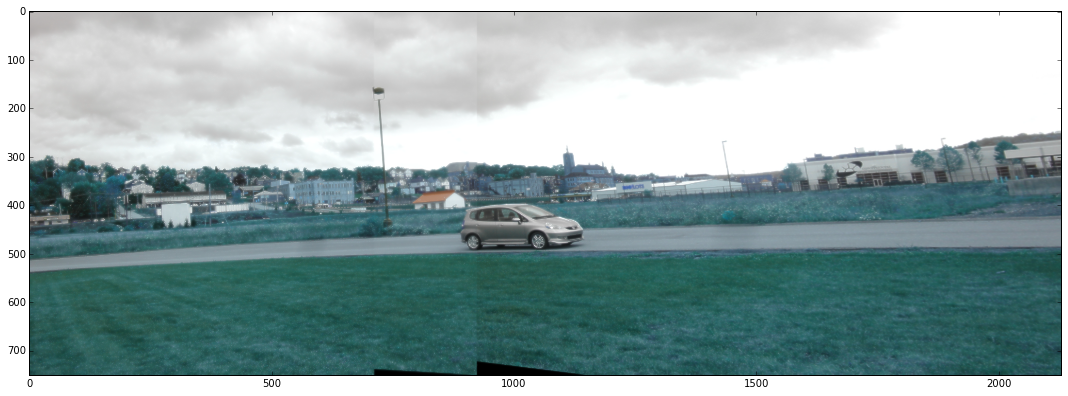

In [225]:
# autocrop(one)
result=stitch(pic_1,pic_2)
# result=stitch(pic_2,pic_1)
# result=autocrop(result)
result=stitch(result,pic_3)
f2=plt.figure()
f2.set_size_inches(18.5, 10.5)
plt.imshow(result)



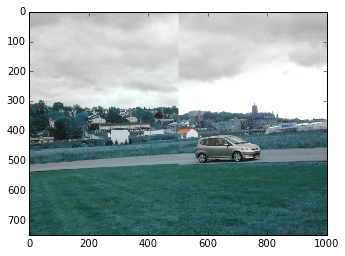

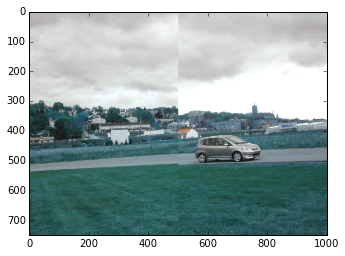